# Projeto: É o Batman?
Este projeto utiliza técnicas de Visão Computacional para detectar se uma imagem contém o Batman. A pipeline está organizada em fases bem definidas para facilitar leitura, manutenção e expansão futura.

## ⚙️ Fase 1 - Coleta e Limpeza dos Dados
Nesta etapa são carregadas as imagens, aplicadas validações básicas para garantir integridade e removidos arquivos corrompidos ou inválidos.

In [ ]:
# CÉLULA 1 — COLETA & FILTRO DAS IMAGENS
%pip install bing-image-downloader
import os
from bing_image_downloader import downloader
from concurrent.futures import ThreadPoolExecutor, as_completed

# Função de download individual
def baixar(keyword, limit, output_dir):
    print(f"Iniciando download: {keyword}")
    downloader.download(
        keyword,
        limit=limit,
        output_dir=output_dir,
        adult_filter_off=True,
        force_replace=False,
        timeout=60  # deixei maior pra evitar timeouts bestas
    )
    print(f"Finalizou: {keyword}")

# Lista de tarefas
tasks = [
    ("Batman", 200, 'dataset'),
    ("city street", 100, 'dataset'),
    ("forest", 100, 'dataset'),
    ("cats", 100, 'dataset'),
    ("dogs", 100, 'dataset'),
    ("dinosaurs", 100, 'dataset'),
    ("people smiling", 100, 'dataset'),
    ("Darth Vader", 100, 'dataset'),
    ("Marvel", 100, 'dataset'),
    ("Black Panther Hero", 100, 'dataset')
]

# Executor paralelizando com até 5 threads
with ThreadPoolExecutor(max_workers=5) as executor:
    future_to_task = {executor.submit(baixar, *t): t[0] for t in tasks}
    for future in as_completed(future_to_task):
        keyword = future_to_task[future]
        try:
            future.result()
        except Exception as e:
            print(f"Erro no download de {keyword}: {e}")

# Limpa para manter apenas jpg, jpeg e png
def clean_initial_downloads(path):
    allowed_exts = ('.jpg', '.jpeg', '.png')
    for root, dirs, files in os.walk(path):
        for file in files:
            if not file.lower().endswith(allowed_exts):
                os.remove(os.path.join(root, file))
                print(f"Removendo {file}")

clean_initial_downloads("dataset")



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: c:\Users\kevin\.pyenv\pyenv-win\versions\3.12.2\python.exe -m pip install --upgrade pip



Iniciando download: Batman
[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\Batman


[!!]Indexing page: 1

Iniciando download: city street
Iniciando download: forest
Iniciando download: cats
Iniciando download: dogs
[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\city street


[!!]Indexing page: 1

[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\dogs


[!!]Indexing page: 1

[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\forest


[!!]Indexing page: 1

[%] Downloading Images to e:\ProjetosCV\isbatman\dataset\cats


[!!]Indexing page: 1

[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from https://commonslibrary.parliament.uk/content/uploads/2018/02/The_City_London-scaled.jpg
[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from https://1.bp.blogspot.com/-9Ys6kScXgf0/W6yApNSb5aI/AAAAAAAABWM/podw57hgXvsVY-JYl7sThU34NT-IcMz-ACLcBGAs/s1600/batman%2Bwallpaper.jpg
[%] Indexed 95 Images on Page 1.


[%] Downloading Image #1 from https:

In [1]:
# CÉLULA 2 — RENOMEIA TUDO QUE NÃO É BATMAN PARA PREFIXO notbatman

import uuid
import os

# Lista de todas as pastas não Batman
not_batman_folders = [
    'dataset/Marvel',
    'dataset/Black Panther Hero',
    'dataset/Darth Vader',
    'dataset/people smiling',
    'dataset/cats',
    'dataset/dogs',
    'dataset/dinosaurs',
    'dataset/forest',
    'dataset/city street'
]

def rename_files(folder_path, prefix):
    for root, _, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                old_path = os.path.join(root, file)
                new_name = f"{prefix}_{uuid.uuid4().hex}.jpg"
                new_path = os.path.join(root, new_name)
                os.rename(old_path, new_path)

for folder in not_batman_folders:
    if os.path.exists(folder):
        rename_files(folder, "notbatman")
    else:
        print(f"Pasta não encontrada e ignorada: {folder}")


In [2]:
# CÉLULA 3 — MOVE TODOS ARQUIVOS PARA dataset/not_batman

import shutil

# Cria pasta final
os.makedirs('dataset/not_batman', exist_ok=True)

def move_all_images(src_folder, dest_folder):
    for root, _, files in os.walk(src_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                src_path = os.path.join(root, file)
                dst_path = os.path.join(dest_folder, file)
                shutil.move(src_path, dst_path)

for folder in not_batman_folders:
    if os.path.exists(folder):
        move_all_images(folder, 'dataset/not_batman')
    else:
        print(f"Pasta não encontrada e ignorada: {folder}")

# Agora remove todas as pastas que não sejam Batman ou not_batman
for folder in os.listdir('dataset'):
    folder_path = os.path.join('dataset', folder)
    if os.path.isdir(folder_path) and folder not in {'Batman', 'not_batman'}:
        shutil.rmtree(folder_path)
        print(f"Pasta removida: {folder_path}")


Pasta removida: dataset\Black Panther Hero
Pasta removida: dataset\cats
Pasta removida: dataset\city street
Pasta removida: dataset\Darth Vader
Pasta removida: dataset\dinosaurs
Pasta removida: dataset\dogs
Pasta removida: dataset\forest
Pasta removida: dataset\Marvel
Pasta removida: dataset\people smiling


## 🧪 Fase 2 - Aumento de Dados e Treinamento do Modelo
Aplicamos técnicas de Data Augmentation para enriquecer o dataset e treinamos um modelo de classificação de imagens utilizando Transfer Learning.

In [1]:
%pip install tensorflow matplotlib
%pip install "tensorflow==2.15.0" "numpy<2.0.0" matplotlib 


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0)
ERROR: No matching distribution found for tensorflow==2.15.0


In [2]:
# CÉLULA 4 — VALIDAÇÃO DAS IMAGENS
from PIL import Image, UnidentifiedImageError
import numpy as np
import tensorflow as tf
import os

def validate_images_hardcore(path):
    count_total = 0
    count_removed = 0
    allowed_exts = ('.jpg', '.jpeg', '.png')
    min_size = (64, 64)  # Tamanho mínimo aceitável

    for class_folder in ['Batman', 'not_batman']:
        folder_path = os.path.join(path, class_folder)
        if not os.path.isdir(folder_path):
            print(f"Pasta não encontrada: {folder_path}")
            continue

        for root, dirs, files in os.walk(folder_path):
            for file in files:
                if not file.lower().endswith(allowed_exts):
                    try:
                        os.remove(os.path.join(root, file))
                        print(f"Removendo arquivo não imagem: {file}")
                        count_removed += 1
                    except Exception as e:
                        print(f"Erro ao remover {file}: {e}")
                    continue

                count_total += 1
                file_path = os.path.join(root, file)
                try:
                    # 1. Verifica header com Pillow
                    with Image.open(file_path) as img:
                        img.verify()

                    # 2. Reabre, força decompressão e garante RGB
                    with Image.open(file_path) as img:
                        img = img.convert('RGB')
                        if img.size[0] < min_size[0] or img.size[1] < min_size[1]:
                            raise ValueError(f"Imagem muito pequena: {img.size}")
                        arr = np.array(img)
                        if arr.ndim != 3 or arr.shape[2] != 3:
                            raise ValueError(f"Imagem não é RGB válida, shape: {arr.shape}")
                        if np.isnan(arr).any() or np.isinf(arr).any():
                            raise ValueError("Imagem contém valores inválidos (NaN/Inf)")

                    # 3. Valida com TensorFlow (decode_image)
                    img_data = tf.io.read_file(file_path)
                    decoded = tf.io.decode_image(img_data, channels=3)
                    if decoded.shape[0] < min_size[0] or decoded.shape[1] < min_size[1]:
                        raise ValueError(f"Imagem muito pequena (TF): {decoded.shape}")

                except (UnidentifiedImageError, OSError, ValueError, tf.errors.InvalidArgumentError) as e:
                    print(f"Removendo inválida: {file_path} | Motivo: {e}")
                    try:
                        os.remove(file_path)
                        count_removed += 1
                    except Exception as e2:
                        print(f"Erro ao remover {file_path}: {e2}")

    print(f"Total verificadas: {count_total}, removidas: {count_removed}")

validate_images_hardcore("dataset")


c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 2. 
  warnings.warn(str(msg))
c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\PIL\Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total verificadas: 1022, removidas: 0


In [4]:
import tensorflow as tf

# Parâmetros
batch_size = 32
img_height = 224
img_width = 224
AUTOTUNE = tf.data.AUTOTUNE

# Augmentation padrão
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.1),
])

# Augmentations específicas por classe
batman_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.3),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomContrast(0.3),
    tf.keras.layers.RandomBrightness(0.2),
])

notbatman_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("vertical"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.05),
    tf.keras.layers.RandomContrast(0.1),
])

# Função de augmentation customizada
def custom_augment(x, y):
    y_flat = tf.reshape(y, [-1])  # Garante 1D

    batman_mask = y_flat == 1.0
    notbatman_mask = y_flat == 0.0

    x_batman = tf.boolean_mask(x, batman_mask)
    x_notbatman = tf.boolean_mask(x, notbatman_mask)
    y_batman = tf.boolean_mask(y_flat, batman_mask)
    y_notbatman = tf.boolean_mask(y_flat, notbatman_mask)

    x_batman_aug = batman_augmentation(x_batman, training=True) if tf.shape(x_batman)[0] > 0 else x_batman
    x_notbatman_aug = notbatman_augmentation(x_notbatman, training=True) if tf.shape(x_notbatman)[0] > 0 else x_notbatman

    x_aug = tf.concat([x_batman_aug, x_notbatman_aug], axis=0)
    y_aug = tf.concat([y_batman, y_notbatman], axis=0)

    idx = tf.random.shuffle(tf.range(tf.shape(x_aug)[0]))
    x_aug = tf.gather(x_aug, idx)
    y_aug = tf.gather(y_aug, idx)

    return x_aug, y_aug

# Carrega datasets com split
train_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='binary'
)

# Aplica augmentation customizada no treino
train_ds = train_ds.map(custom_augment, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

print("✅ Dataset carregado e augmentation inteligente aplicado.")


Found 1022 files belonging to 2 classes.
Using 818 files for training.
Found 1022 files belonging to 2 classes.
Using 204 files for validation.
✅ Dataset carregado e augmentation inteligente aplicado.


In [5]:
from tensorflow.keras import layers, models, callbacks

# Célula 6: DOIS MODELOS — BATMAN E NOT BATMAN

def build_model():
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights='imagenet'
    )
    base_model.trainable = True
    for layer in base_model.layers[:-30]:
        layer.trainable = False

    inputs = tf.keras.Input(shape=(img_height, img_width, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = base_model(x, training=True)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.4)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    model = models.Model(inputs, outputs)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# Modelo para reconhecer Batman
model_batman = build_model()

# Modelo para reconhecer Not Batman
model_notbatman = build_model()

# Callbacks para ambos
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
checkpoint_batman = callbacks.ModelCheckpoint('best_model_batman.h5', monitor='val_loss', save_best_only=True)
checkpoint_notbatman = callbacks.ModelCheckpoint('best_model_notbatman.h5', monitor='val_loss', save_best_only=True)

print("Dois modelos criados: model_batman e model_notbatman.")


Dois modelos criados: model_batman e model_notbatman.


In [6]:
# Célula 7: TREINAMENTO MELHORADO — Dois modelos

epochs = 50

# Treinamento do modelo Batman
history_batman = model_batman.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint_batman]
)

# Treinamento do modelo Not Batman
history_notbatman = model_notbatman.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stop, checkpoint_notbatman]
)


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5448 - loss: 0.8737

26/26 ━━━━━━━━━━━━━━━━━━━━ 104s 3s/step - accuracy: 0.5451 - loss: 0.8739 - val_accuracy: 0.5098 - val_loss: 0.8236
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6705 - loss: 0.6872

26/26 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.6703 - loss: 0.6866 - val_accuracy: 0.6765 - val_loss: 0.6848
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7425 - loss: 0.5907

26/26 ━━━━━━━━━━━━━━━━━━━━ 87s 3s/step - accuracy: 0.7430 - loss: 0.5903 - val_accuracy: 0.7598 - val_loss: 0.5737
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7900 - loss: 0.5172

26/26 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.7895 - loss: 0.5175 - val_accuracy: 0.8235 - val_loss: 0.4875
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.8045 - loss: 0.4303 - val_accuracy: 0.7941 - val_loss: 0.5886
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.8224 - loss: 0.4409 - val_accuracy: 0.7843 - val_loss: 0.6766
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.8840 - loss: 0.3203 - val_accuracy: 0.8088 - val_loss: 0.7961
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9091 - loss: 0.2947 - val_accuracy: 0.8333 - val_loss: 0.6584
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9062 - loss: 0.2833 - val_accuracy: 0.8873 - val_loss: 0.5273
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 70s 3s/step - accuracy: 0.9293 - loss: 0.2328 - val_accuracy: 0.8873 - val_loss: 0.5928
Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5279 - loss: 0.8769

26/26 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.5299 - loss: 0.8742 - val_accuracy: 0.5147 - val_loss: 0.8130
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7138 - loss: 0.6274

26/26 ━━━━━━━━━━━━━━━━━━━━ 91s 3s/step - accuracy: 0.7133 - loss: 0.6287 - val_accuracy: 0.6618 - val_loss: 0.7302
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7106 - loss: 0.6015

26/26 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.7112 - loss: 0.6003 - val_accuracy: 0.7255 - val_loss: 0.6509
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7328 - loss: 0.5354

26/26 ━━━━━━━━━━━━━━━━━━━━ 86s 3s/step - accuracy: 0.7335 - loss: 0.5352 - val_accuracy: 0.7745 - val_loss: 0.6399
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8121 - loss: 0.4252 - val_accuracy: 0.7892 - val_loss: 0.6404
Epoch 6/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 78s 3s/step - accuracy: 0.8667 - loss: 0.3519 - val_accuracy: 0.7941 - val_loss: 0.6940
Epoch 7/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 75s 3s/step - accuracy: 0.8745 - loss: 0.3437 - val_accuracy: 0.8137 - val_loss: 0.6864
Epoch 8/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.8906 - loss: 0.3119 - val_accuracy: 0.8088 - val_loss: 0.8210
Epoch 9/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 82s 3s/step - accuracy: 0.8919 - loss: 0.3636 - val_accuracy: 0.7696 - val_loss: 1.0709
Epoch 10/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 81s 3s/step - accuracy: 0.9267 - loss: 0.2447 - val_accuracy: 0.7892 - val_loss: 0.9390


## 📉 Fase 3 - Avaliação do Modelo
Apresentamos métricas de desempenho, como acurácia, matriz de confusão, curva ROC, etc.

   ---------------------------------------- 0.0/10.7 MB ? eta -:--:--
   ---------------------------------------  10.5/10.7 MB 65.5 MB/s eta 0:00:01
   ---------------------------------------- 10.7/10.7 MB 47.5 MB/s eta 0:00:00

   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------------------- 1/3 [joblib]
   ------------- -------------

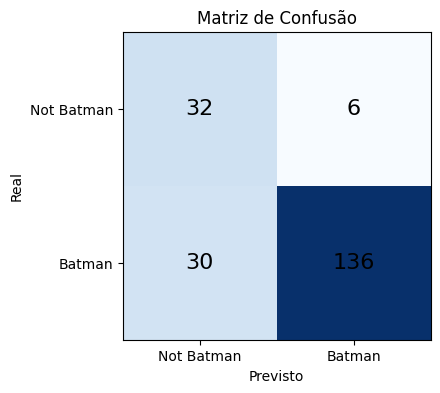

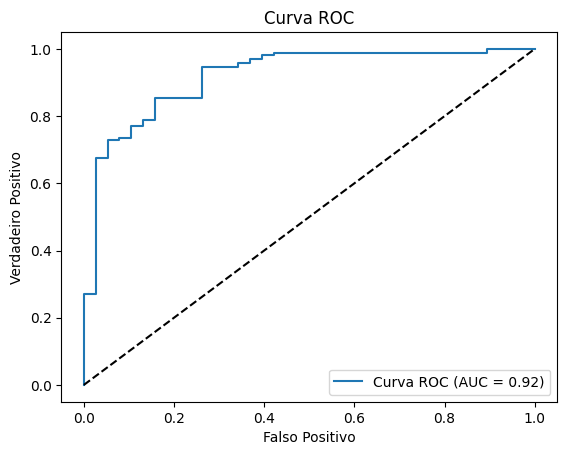

A matriz de confusão mostra quantas imagens o modelo acertou ou errou para cada classe.
A curva ROC mostra a capacidade do modelo em distinguir Batman de Not Batman. Quanto mais próximo de 1, melhor.


In [8]:
%pip install scikit-learn

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

# Avaliação do modelo model_batman: acurácia, matriz de confusão e curva ROC

import matplotlib.pyplot as plt

# Gera previsões no conjunto de validação
y_true = []
y_pred = []
y_prob = []

for images, labels in val_ds:
    probs = model_batman.predict(images).flatten()
    preds = (probs > 0.5).astype(int)
    y_true.extend(labels.numpy().astype(int))
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

# Acurácia
accuracy = np.mean(y_true == y_pred)
print(f"Acurácia do modelo: {accuracy*100:.2f}%")

# Relatório de classificação
print("\nRelatório detalhado:")
print(classification_report(y_true, y_pred, target_names=["Not Batman", "Batman"]))

# Matriz de confusão
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4,4))
plt.imshow(cm, cmap='Blues')
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.xticks([0,1], ["Not Batman", "Batman"])
plt.yticks([0,1], ["Not Batman", "Batman"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=16)
plt.show()

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

print("A matriz de confusão mostra quantas imagens o modelo acertou ou errou para cada classe.")
print("A curva ROC mostra a capacidade do modelo em distinguir Batman de Not Batman. Quanto mais próximo de 1, melhor.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Acurácia do modelo (Not Batman): 56.15%

Relatório detalhado (Not Batman):
              precision    recall  f1-score   support

  Not Batman       0.45      0.97      0.62        38
      Batman       0.99      0.73      0.84       166

    accuracy                           0.77       204
   macro avg       0.72      0.85      0.73       204
weighted avg       0.89      0.77      0.80       204



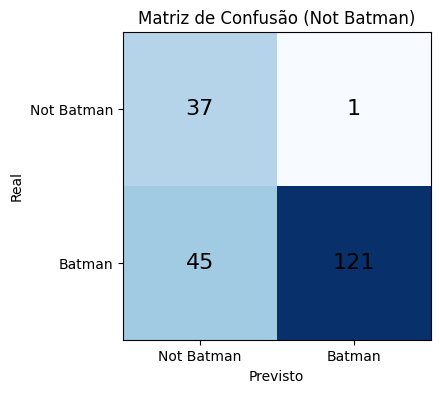

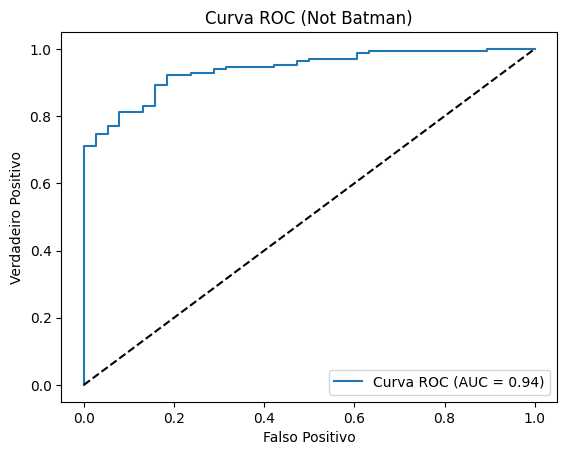

A acurácia mostra o percentual de acertos do modelo.
A matriz de confusão mostra quantas imagens o modelo acertou ou errou para cada classe (Batman ou Não Batman).
A curva ROC mostra a capacidade do modelo em distinguir Batman de Não Batman. Quanto mais próximo de 1, melhor.


In [9]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np

import matplotlib.pyplot as plt

# Avaliação do modelo model_notbatman: acurácia, matriz de confusão e curva ROC

# Gera previsões no conjunto de validação
y_true_nb = []
y_pred_nb = []
y_prob_nb = []

for images, labels in val_ds:
    probs = model_notbatman.predict(images).flatten()
    preds = (probs > 0.5).astype(int)
    y_true_nb.extend(labels.numpy().astype(int))
    y_pred_nb.extend(preds)
    y_prob_nb.extend(probs)

y_true_nb = np.array(y_true_nb)
y_pred_nb = np.array(y_pred_nb)
y_prob_nb = np.array(y_prob_nb)

# Acurácia
accuracy_nb = np.mean(y_true_nb == y_pred_nb)
print(f"Acurácia do modelo (Not Batman): {accuracy_nb*100:.2f}%")

# Relatório de classificação
print("\nRelatório detalhado (Not Batman):")
print(classification_report(y_true_nb, y_pred_nb, target_names=["Not Batman", "Batman"]))

# Matriz de confusão
cm_nb = confusion_matrix(y_true_nb, y_pred_nb)
plt.figure(figsize=(4,4))
plt.imshow(cm_nb, cmap='Blues')
plt.title("Matriz de Confusão (Not Batman)")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.xticks([0,1], ["Not Batman", "Batman"])
plt.yticks([0,1], ["Not Batman", "Batman"])
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm_nb[i, j], ha='center', va='center', color='black', fontsize=16)
plt.show()

# Curva ROC
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_true_nb, y_prob_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb)
plt.figure()
plt.plot(fpr_nb, tpr_nb, label=f'Curva ROC (AUC = {roc_auc_nb:.2f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('Falso Positivo')
plt.ylabel('Verdadeiro Positivo')
plt.title('Curva ROC (Not Batman)')
plt.legend(loc='lower right')
plt.show()

print("A acurácia mostra o percentual de acertos do modelo.")
print("A matriz de confusão mostra quantas imagens o modelo acertou ou errou para cada classe (Batman ou Não Batman).")
print("A curva ROC mostra a capacidade do modelo em distinguir Batman de Não Batman. Quanto mais próximo de 1, melhor.")

## 🦇 Fase Final - Testes com Imagens Externas
Aqui testamos o modelo com imagens inéditas para verificar sua robustez na vida real. A ideia é saber: "É o Batman?"

Note: you may need to restart the kernel to use updated packages.


c:\Users\kevin\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129415 (\N{BAT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


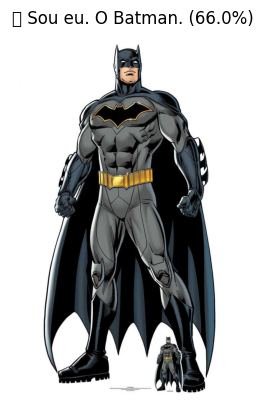

In [ ]:
# Célula final: TESTE COM LINK DE IMAGEM
%pip install matplotlib
import requests
from PIL import Image
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
import os

# Link direto da imagem
url = "http://cdn11.bigcommerce.com/s-ydriczk/images/stencil/1500x1500/products/89093/93728/DC-Comics-Batman-Caped-Crusader-official-cardboard-cutout-buy-now-at-starstills__04189.1582849820.jpg?c=2&imbypass=on"

# Baixa a imagem e salva
response = requests.get(url)
if "image" not in response.headers["Content-Type"]:
    raise ValueError("Esse link não parece ser de imagem. Use um link direto (.jpg, .png)")

img = Image.open(BytesIO(response.content)).convert('RGB')
os.makedirs("testebatman", exist_ok=True)
img_path = os.path.join("testebatman", "img_teste.jpg")
img.save(img_path)

# Prepara imagem para o modelo
img_resized = img.resize((img_width, img_height))
img_array = tf.keras.applications.mobilenet_v2.preprocess_input(np.array(img_resized))
img_array = np.expand_dims(img_array, axis=0)

# Faz predição com ambos os modelos
pred_batman = model_batman.predict(img_array, verbose=0)[0][0]
pred_notbatman = model_notbatman.predict(img_array, verbose=0)[0][0]

# Interpreta os resultados (threshold ajustado pra sensibilidade)
batman_pct = pred_batman * 100
notbatman_pct = (1 - pred_notbatman) * 100  # Inverte pois é "not batman"

# Mostra resultado
plt.imshow(img)
plt.axis('off')

# Combina os scores com lógica de decisão
if pred_batman > 0.65:
    plt.title(f"I'm Batman. ({batman_pct:.1f}%)")
elif pred_batman < 0.35:
    plt.title(f"Achou que era o morcegão? hahahahhahahahahahahahah. ({notbatman_pct:.1f}%)")
else:
    plt.title(f"Ambíguo. Parece meio morcego, meio qualquer coisa.\nBatman: {batman_pct:.1f}%, Not Batman: {notbatman_pct:.1f}%")


plt.show()
